In [51]:
import time
import tqdm
import numpy as np
import torchvision.models as models
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
from PIL import Image
import pandas as pd

## ResNet50 Training

### Our target is to predict a number of the squares on the photo. In 'train.csv' we have paths to images and two features containing: actual number of squares; type of the picture. We'll use both of the columns as it could help the NN to output a better result depending on the type of the picture, not only based on the quantity of squares.

ResNet with 50 layers was chosen in preference to 101 layer NN due to the size of input data and the simplicity of the task. ResNet34 was also trained, but the 50-layered model showed better RMSE results.<br>
We have the train dataset of paths to 3000 images, containing figures overlaying each other. Sample images look like that:

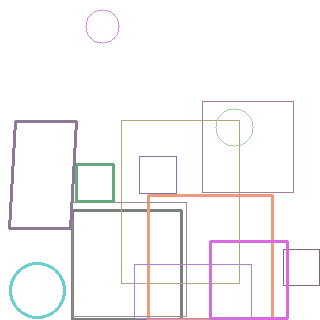

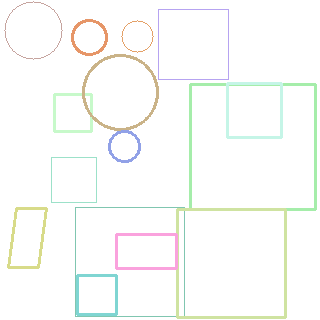

In [91]:
aa = pd.read_csv('Task2/train.csv')

a = pd.DataFrame(aa.iloc[:2500])
b = pd.DataFrame(aa.iloc[2500:])
a.to_csv('Task2/a2500.csv', index=False)
b.to_csv('Task2/b500.csv', index=False)

Let's initialize a dataset to prepare it for a PyTorch interface.

In [92]:
class ImgDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        # print(img_path)
        image = Image.open('Task2/' + img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if self.dataframe.shape[1] > 1:
            label1 = self.dataframe.iloc[idx, 1]
            label2 = self.dataframe.iloc[idx, 2]
            return image, (label1, label2)
        else:
            return image

Reducing pixel size to 224 (ResNet standard), converting to tensor and normalizing:

In [93]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create dataset
train_dataset = ImgDataset(csv_file='Task2/a2500.csv', transform=transform)
val_dataset = ImgDataset(csv_file='Task2/b500.csv', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Converting the final output layer to have two features as an output:

In [94]:
def get_resnet50():
    resnet = torchvision.models.resnet50(pretrained=True)

    # Substitute the fc output layer
    resnet.fc = torch.nn.Linear(resnet.fc.in_features, 2)
    torch.nn.init.xavier_uniform_(resnet.fc.weight)
    return resnet

### Unfreezing ResNet50

In [95]:
device = 'cuda'
resnet50 = get_resnet50().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [96]:
# Замораживаем все, чтобы разморозить только
for p in resnet50.parameters():
    p.requires_grad = False

In [97]:
# Unfreeze head layer

resnet50.fc.weight.requires_grad = True
resnet50.fc.bias.requires_grad = True

# And 10 more layers

resnet50.layer4[2].bn3.weight.requires_grad = True
resnet50.layer4[2].bn3.bias.requires_grad = True

resnet50.layer4[2].conv3.weight.requires_grad = True

resnet50.layer4[2].bn2.weight.requires_grad = True
resnet50.layer4[2].bn2.bias.requires_grad = True

resnet50.layer4[2].conv2.weight.requires_grad = True

resnet50.layer4[2].bn1.weight.requires_grad = True
resnet50.layer4[2].bn1.bias.requires_grad = True

resnet50.layer4[2].conv1.weight.requires_grad = True

resnet50.layer4[1].bn3.weight.requires_grad = True
resnet50.layer4[1].bn3.bias.requires_grad = True

resnet50.layer4[1].conv3.weight.requires_grad = True

resnet50.layer4[1].bn2.weight.requires_grad = True
resnet50.layer4[1].bn2.bias.requires_grad = True

resnet50.layer4[1].conv2.weight.requires_grad = True


#### Train function (we save weights for each epoch better than previous and there is a logic of stopping the train process based on loss - if it is not decreasing):

In [98]:
def train(net, train_dataloader, valid_dataloader, criterion, optimizer, scheduler=None, epochs=10, device='cuda'):
    start = time.time()
    print(f'Training for {epochs} epochs on {device}')

    best_valid_loss = float('inf')
    best_epoch = 0
    epochs_no_improve = 0
    for epoch in tqdm.tqdm(range(1, epochs + 1), total=epochs, unit="epoch"):
        epoch_start = time.time()

        net.train()
        train_loss, train_sq_error = 0., 0.
        for item in train_dataloader:
            X = item[0].to(device)
            y = item[1]
            y1, y2 = y[0].to(device).float(), y[1].to(device).float()

            optimizer.zero_grad()
            pred1, pred2 = net(X).t()
            loss1 = criterion(pred1, y1)
            loss2 = criterion(pred2, y2)
            loss = loss1 + loss2
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X.size(0)
            train_sq_error += ((pred1 - y1) ** 2).sum().item() + ((pred2 - y2) ** 2).sum().item()
        train_loss /= len(train_dataloader.dataset)
        train_rmse = (train_sq_error / len(train_dataloader.dataset)) ** 0.5

        valid_loss, valid_sq_error = None, 0.
        if valid_dataloader is not None:
            net.eval()
            valid_loss = 0.
            with torch.no_grad():
                for item in valid_dataloader:
                    X = item[0].to(device)
                    y = item[1]
                    y1, y2 = y[0].to(device).float(), y[1].to(device).float()
                    pred1, pred2 = net(X).t()

                    loss1 = criterion(pred1, y1)
                    loss2 = criterion(pred2, y2)
                    loss = loss1 + loss2
                    valid_loss += loss.item() * X.size(0)
                    valid_sq_error += ((pred1 - y1) ** 2).sum().item() + ((pred2 - y2) ** 2).sum().item()

            valid_loss /= len(valid_dataloader.dataset)
            valid_rmse = (valid_sq_error / len(valid_dataloader.dataset)) ** 0.5

            if valid_loss < best_valid_loss - 0.0005:
                torch.save(net.state_dict(), f'./unfreezed5_resnet50/weights_epoch_{epoch}.pth')
                best_valid_loss = valid_loss
                best_epoch = epoch
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve == 5:
                print("Early stopping triggered")
                break

        epoch_end = time.time()
        print(f'\nEpoch {epoch}/{epochs} completed in {epoch_end - epoch_start:.2f} sec')
        print(f'Training Loss: {train_loss:.4f}, Training RMSE: {train_rmse:.4f}')
        if valid_loss is not None:
            print(f'Validation Loss: {valid_loss:.4f}, Validation RMSE: {valid_rmse:.4f}')
        print()

    print(f'\nTotal training time: {time.time() - start:.1f} seconds')
    print(f'Best epoch: {best_epoch} with validation loss: {best_valid_loss:.4f}')
    return net, best_epoch

### The train process, including unfrozen layers of the model. As we found out, 10 epochs is a decent amount for this task.

In [99]:
device = 'cuda' if torch.cuda.is_available() else 'cuda'
lr, weight_decay, epochs = 1e-5, 5e-4, 20

resnet50 = get_resnet50().to(device)

# Standard CrossEntropy Loss for multi-class classification problems
criterion = torch.nn.MSELoss()

# params_1x are the parameters of the resnetwork body, i.e., of all layers except the FC layers
params_1x = [param for name, param in resnet50.named_parameters() if 'fc' not in str(name)]

# including unfrozen layers
params_to_update = params_1x + list(resnet50.layer4[2].bn3.parameters()) + list(resnet50.layer4[2].conv3.parameters()) + list(resnet50.layer4[2].conv2.parameters()) + list(resnet50.layer4[2].bn2.parameters())
params_to_update += list(resnet50.layer4[2].bn1.parameters()) + list(resnet50.layer4[2].conv1.parameters())

params_to_update += list(resnet50.layer4[1].bn1.parameters()) + list(resnet50.layer4[1].conv1.parameters())
params_to_update += list(resnet50.layer4[1].bn2.parameters()) + list(resnet50.layer4[1].conv2.parameters())
params_to_update += list(resnet50.layer4[1].bn3.parameters()) + list(resnet50.layer4[1].conv3.parameters())
params_to_update += list(resnet50.layer4[1].bn2.parameters()) + list(resnet50.layer4[1].conv2.parameters())

# Params with higher learning rate speed
optimizer = torch.optim.Adam([
    {'params': params_to_update},
    {'params': resnet50.fc.parameters(), 'lr': lr * 10}
], lr=lr, weight_decay=weight_decay)

resnet50, best_epoch = train(resnet50, train_loader, val_loader, criterion, optimizer, None, 10, device)

/usr/local/lib/python3.10/dist-packages/torch/_compile.py:24: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return torch._dynamo.disable(fn, recursive)(*args, **kwargs)


Training for 10 epochs on cuda


 10%|█         | 1/10 [00:28<04:20, 28.90s/epoch]


Epoch 1/10 completed in 28.90 sec
Training Loss: 17.8632, Training RMSE: 4.2265
Validation Loss: 9.7436, Validation RMSE: 3.1215



 20%|██        | 2/10 [00:58<03:55, 29.39s/epoch]


Epoch 2/10 completed in 29.73 sec
Training Loss: 3.8422, Training RMSE: 1.9601
Validation Loss: 2.0982, Validation RMSE: 1.4485



 30%|███       | 3/10 [01:28<03:28, 29.73s/epoch]


Epoch 3/10 completed in 30.12 sec
Training Loss: 1.1354, Training RMSE: 1.0655
Validation Loss: 1.7875, Validation RMSE: 1.3370



 40%|████      | 4/10 [01:58<02:57, 29.65s/epoch]


Epoch 4/10 completed in 29.53 sec
Training Loss: 0.6983, Training RMSE: 0.8356
Validation Loss: 1.7916, Validation RMSE: 1.3385



 50%|█████     | 5/10 [02:28<02:28, 29.80s/epoch]


Epoch 5/10 completed in 30.06 sec
Training Loss: 0.4686, Training RMSE: 0.6845
Validation Loss: 1.7381, Validation RMSE: 1.3184



 60%|██████    | 6/10 [02:59<02:00, 30.09s/epoch]


Epoch 6/10 completed in 30.65 sec
Training Loss: 0.2917, Training RMSE: 0.5401
Validation Loss: 1.7508, Validation RMSE: 1.3232



 70%|███████   | 7/10 [03:29<01:30, 30.12s/epoch]


Epoch 7/10 completed in 30.17 sec
Training Loss: 0.2296, Training RMSE: 0.4791
Validation Loss: 1.7443, Validation RMSE: 1.3207



 80%|████████  | 8/10 [03:59<01:00, 30.33s/epoch]


Epoch 8/10 completed in 30.79 sec
Training Loss: 0.1892, Training RMSE: 0.4350
Validation Loss: 1.7293, Validation RMSE: 1.3150



 90%|█████████ | 9/10 [04:30<00:30, 30.25s/epoch]


Epoch 9/10 completed in 30.05 sec
Training Loss: 0.1713, Training RMSE: 0.4138
Validation Loss: 1.7082, Validation RMSE: 1.3070



100%|██████████| 10/10 [04:59<00:00, 29.98s/epoch]


Epoch 10/10 completed in 29.74 sec
Training Loss: 0.1827, Training RMSE: 0.4274
Validation Loss: 1.7169, Validation RMSE: 1.3103


Total training time: 299.8 seconds
Best epoch: 9 with validation loss: 1.7082


### Now we initialize the weights of model from the best epoch and make a prediction on the 'test.csv' dataset. It contained 6000 images and the submission RMSE was 2.611. 

In [100]:
# Load the best saved model weights
resnet50 = get_resnet50()  # Initialize the model architecture
best_model_path =  f'./unfreezed5_resnet50/weights_epoch_{best_epoch}.pth' # Replace with your model's path
resnet50.load_state_dict(torch.load(best_model_path))
resnet50.eval().to(device)

# Read the data
test_df = pd.read_csv('Task2/test.csv')
predictions = pd.DataFrame(np.arange(0, len(test_df), 1), columns=['label'])

# Loop for predictions
for i in tqdm.tqdm(range(len(test_df))):
    img = Image.open('Task2/' + test_df.iloc[i, 0])
    img = transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)  # Move the image tensor to the device

    # Predict
    with torch.no_grad():
        output = resnet50(img)
        number_of_squares = output[0, 0]
        number_of_squares = round(number_of_squares.item())
        predictions.iloc[i, 0] = number_of_squares

# Save the predictions
predictions.to_csv('./Task2/result.csv')


100%|██████████| 6000/6000 [01:10<00:00, 84.63it/s]
